In [1]:
import pandas as pd
import numpy as np
import glob
import importlib
import pickle

In [2]:
import xgboost as xgb

In [4]:
import shap

In [21]:
t = samples["QCD"]

In [13]:
features = ['ht', 'aplanarity', 'sphericity', 'chargeEta', 'met', 'deltaPhiTauMet', 'mt', 'mTauJet']

In [15]:
X = t[features]

In [17]:
bdt = pickle.load(open("syst_scale/bdt/bdt.pkl", "rb"))

In [18]:
explainer = shap.TreeExplainer(bdt)

In [19]:
shap_values = explainer.shap_values(X)

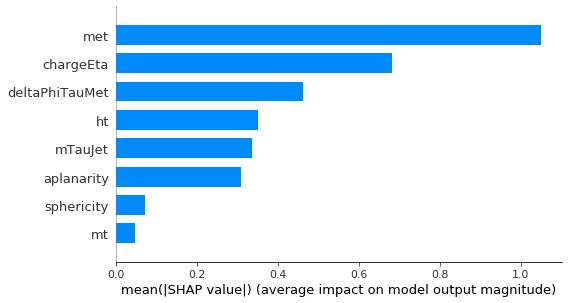

In [22]:
shap.summary_plot(shap_values, X,  plot_type="bar")

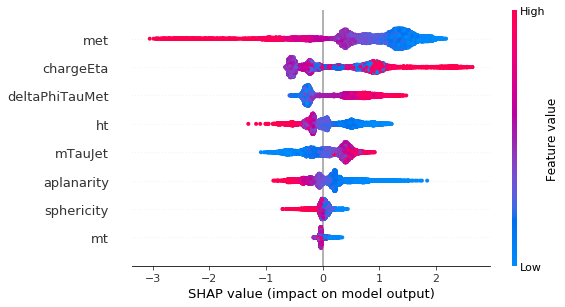

In [23]:
shap.summary_plot(shap_values, X)

## BDT training

In [9]:
CAND_DIR = "cand_loose"
corrections = ["centJER", "jes_up", "jes_down", "jes_up_old", "jes_down_old", "jer_up", "jer_down", "tau_eup", "tau_edown"]

def get_samples():

    files = glob.glob( CAND_DIR + "/*.h5")
    samples = {}
    for sample in files:
        sample_name = sample.split("/")[-1][:-3]
        print(sample_name)
        if (sample_name != "Data") & (sample_name != "QCD"):
            for key in ["central", "met_up", "met_down"] + corrections:
                samples[sample_name + "_" + key] = pd.read_hdf(sample, sample_name + "_" + key)
        else:
            samples[sample_name] = pd.read_hdf(sample)
            
    return samples

In [10]:
samples = get_samples()

Data
QCD
STJets
TTJets_bkg
TTJets_signal
WZJets


In [4]:
samples.keys()

dict_keys(['Data', 'QCD', 'STJets_central', 'STJets_met_up', 'STJets_met_down', 'STJets_centJER', 'STJets_jes_up', 'STJets_jes_down', 'STJets_jes_up_old', 'STJets_jes_down_old', 'STJets_jer_up', 'STJets_jer_down', 'STJets_tau_eup', 'STJets_tau_edown', 'TTJets_bkg_central', 'TTJets_bkg_met_up', 'TTJets_bkg_met_down', 'TTJets_bkg_centJER', 'TTJets_bkg_jes_up', 'TTJets_bkg_jes_down', 'TTJets_bkg_jes_up_old', 'TTJets_bkg_jes_down_old', 'TTJets_bkg_jer_up', 'TTJets_bkg_jer_down', 'TTJets_bkg_tau_eup', 'TTJets_bkg_tau_edown', 'TTJets_signal_central', 'TTJets_signal_met_up', 'TTJets_signal_met_down', 'TTJets_signal_centJER', 'TTJets_signal_jes_up', 'TTJets_signal_jes_down', 'TTJets_signal_jes_up_old', 'TTJets_signal_jes_down_old', 'TTJets_signal_jer_up', 'TTJets_signal_jer_down', 'TTJets_signal_tau_eup', 'TTJets_signal_tau_edown', 'WZJets_central', 'WZJets_met_up', 'WZJets_met_down', 'WZJets_centJER', 'WZJets_jes_up', 'WZJets_jes_down', 'WZJets_jes_up_old', 'WZJets_jes_down_old', 'WZJets_jer_

In [4]:
samples["TTJets_signal_centJER"]["pdf_up"] = samples["TTJets_signal_centJER"]["pdf_up"].fillna(0.)
samples["TTJets_signal_centJER"]["pdf_down"] = samples["TTJets_signal_centJER"]["pdf_down"].fillna(0.)
samples["TTJets_bkg_centJER"]["pdf_up"] = samples["TTJets_bkg_centJER"]["pdf_up"].fillna(0.)
samples["TTJets_bkg_centJER"]["pdf_down"] = samples["TTJets_bkg_centJER"]["pdf_down"].fillna(0.)

In [6]:
len(samples["QCD"])

11235

In [5]:
import ml

Welcome to JupyROOT 6.20/06


Prepare training data
['Jet_pt', 'Jet_px', 'Jet_py', 'Jet_pz', 'Jet_e', 'Jet_eta', 'Jet_phi', 'Jet_mass', 'Jet_csvDisc', 'Jet_flavour', 'Tau_pt', 'Tau_px', 'Tau_py', 'Tau_pz', 'Tau_e', 'Tau_eta', 'Tau_phi', 'Tau_mass', 'Tau_charge', 'MET_pt', 'MET_px', 'MET_py', 'MET_pz', 'MET_e', 'MET_met', 'event', 'run', 'luminosityBlock', 'HLT_QuadJet40_IsoPFTau40', 'HLT_QuadJet45_IsoPFTau45', 'genEvent_tmeme', 'nJets', 'Jet_nbtags', 'ht', 'aplanarity', 'sphericity', 'chargeEta', 'met', 'deltaPhiTauMet', 'mt', 'mTauJet', 'Jet_btagSF', 'Jet_btagSF_up', 'Jet_btagSF_down', 'Jet_beff', 'Jet_btag_weight1', 'Jet_btag_weight1_up', 'Jet_btag_weight1_down', 'trigger_weight', 'trigger_weight_up', 'trigger_weight_down', 'norm', 'norm_up', 'norm_down', 'train_flag']


/eos/home-l/llayer/cmsopen/columnar/ml.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  signal_train["weights"] = signal_train['trigger_weight'] * signal_train['Jet_btag_weight1']
/eos/home-l/llayer/cmsopen/columnar/ml.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  signal_train["weights"] = signal_train["weights"] * (1. / np.mean(signal_train["weights"]))
/eos/home-l/llayer/cmsopen/columnar/ml.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Train model


/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Importance
ht 0.040442035
aplanarity 0.094627365
sphericity 0.035212163
chargeEta 0.10917759
met 0.51533014
deltaPhiTauMet 0.1477881
mt 0.02040142
mTauJet 0.037021138
Predicting...


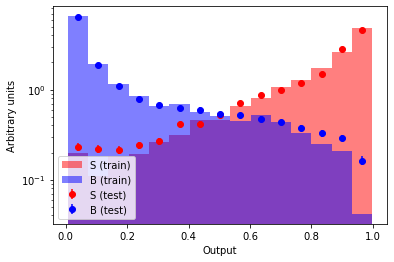

In [6]:
importlib.reload(ml)
ml.train(samples, n_sig=4000, n_bkg=4000, ntrees=1000, lr=0.01)

In [9]:
samples.keys()

dict_keys(['Data', 'QCD', 'STJets_central', 'STJets_met_up', 'STJets_met_down', 'STJets_centJER', 'STJets_jes_up', 'STJets_jes_down', 'STJets_jes_up_old', 'STJets_jes_down_old', 'STJets_jer_up', 'STJets_jer_down', 'STJets_tau_eup', 'STJets_tau_edown', 'TTJets_bkg_central', 'TTJets_bkg_met_up', 'TTJets_bkg_met_down', 'TTJets_bkg_centJER', 'TTJets_bkg_jes_up', 'TTJets_bkg_jes_down', 'TTJets_bkg_jes_up_old', 'TTJets_bkg_jes_down_old', 'TTJets_bkg_jer_up', 'TTJets_bkg_jer_down', 'TTJets_bkg_tau_eup', 'TTJets_bkg_tau_edown', 'TTJets_signal_central', 'TTJets_signal_met_up', 'TTJets_signal_met_down', 'TTJets_signal_centJER', 'TTJets_signal_jes_up', 'TTJets_signal_jes_down', 'TTJets_signal_jes_up_old', 'TTJets_signal_jes_down_old', 'TTJets_signal_jer_up', 'TTJets_signal_jer_down', 'TTJets_signal_tau_eup', 'TTJets_signal_tau_edown', 'WZJets_central', 'WZJets_met_up', 'WZJets_met_down', 'WZJets_centJER', 'WZJets_jes_up', 'WZJets_jes_down', 'WZJets_jes_up_old', 'WZJets_jes_down_old', 'WZJets_jer_

## Histograms

In [5]:
import plot
import importlib

In [6]:
importlib.reload(plot)

<module 'plot' from '/eos/home-l/llayer/cmsopen/columnar/plot.py'>

In [2]:
variables = [
    {"var_name" : "bdt", "bins" : 30, "xlow" : 0., "xup" : 1., "xtitle" : "bdt"}
]

In [17]:
plot.vars_to_histos(samples, variables, file_name = "bdt_nb")

Data bdt None
QCD bdt None
STJets_central bdt None
STJets_met_up bdt None
STJets_met_down bdt None
STJets_centJER bdt None
STJets_centJER bdt btag_up
STJets_centJER bdt btag_down
STJets_centJER bdt trigger_up
STJets_centJER bdt trigger_down
STJets_centJER bdt xsec_up
STJets_centJER bdt xsec_down
STJets_jes_up bdt None
STJets_jes_down bdt None
STJets_jes_up_old bdt None
STJets_jes_down_old bdt None
STJets_jer_up bdt None
STJets_jer_down bdt None
STJets_tau_eup bdt None
STJets_tau_edown bdt None
TTJets_bkg_central bdt None
TTJets_bkg_met_up bdt None
TTJets_bkg_met_down bdt None
TTJets_bkg_centJER bdt None
TTJets_bkg_centJER bdt btag_up
TTJets_bkg_centJER bdt btag_down
TTJets_bkg_centJER bdt trigger_up
TTJets_bkg_centJER bdt trigger_down
TTJets_bkg_centJER bdt xsec_up
TTJets_bkg_centJER bdt xsec_down
TTJets_bkg_centJER bdt pdf_up
TTJets_bkg_centJER bdt pdf_down
TTJets_bkg_jes_up bdt None
TTJets_bkg_jes_down bdt None
TTJets_bkg_jes_up_old bdt None
TTJets_bkg_jes_down_old bdt None
TTJets_bk

In [21]:
import ROOT

In [31]:
f.ls()

TFile**		histos/bdt_nb.root	
 TFile*		histos/bdt_nb.root	
  OBJ: TH1D	TTJets_signal_centJER_bdt	TTJets_signal_centJER_bdt : 0 at: 0xceca7fa0
  KEY: TH1D	Data_bdt;1	Data_bdt
  KEY: TH1D	QCD_bdt;1	QCD_bdt
  KEY: TH1D	STJets_central_bdt;1	STJets_central_bdt
  KEY: TH1D	STJets_met_up_bdt;1	STJets_met_up_bdt
  KEY: TH1D	STJets_met_down_bdt;1	STJets_met_down_bdt
  KEY: TH1D	STJets_centJER_bdt;1	STJets_centJER_bdt
  KEY: TH1D	STJets_centJER_btag_up_bdt;1	STJets_centJER_bdt_btag_up
  KEY: TH1D	STJets_centJER_btag_down_bdt;1	STJets_centJER_bdt_btag_down
  KEY: TH1D	STJets_centJER_trigger_up_bdt;1	STJets_centJER_bdt_trigger_up
  KEY: TH1D	STJets_centJER_trigger_down_bdt;1	STJets_centJER_bdt_trigger_down
  KEY: TH1D	STJets_centJER_xsec_up_bdt;1	STJets_centJER_bdt_xsec_up
  KEY: TH1D	STJets_centJER_xsec_down_bdt;1	STJets_centJER_bdt_xsec_down
  KEY: TH1D	STJets_jes_up_bdt;1	STJets_jes_up_bdt
  KEY: TH1D	STJets_jes_down_bdt;1	STJets_jes_down_bdt
  KEY: TH1D	STJets_jes_up_old_bdt;1	STJets_jes_up_old

In [22]:
f = ROOT.TFile("histos/bdt_nb.root")

In [32]:
h = f.Get("TTJets_signal_centJER_pdf_up_bdt")

In [33]:
type(h)

ROOT.TH1D

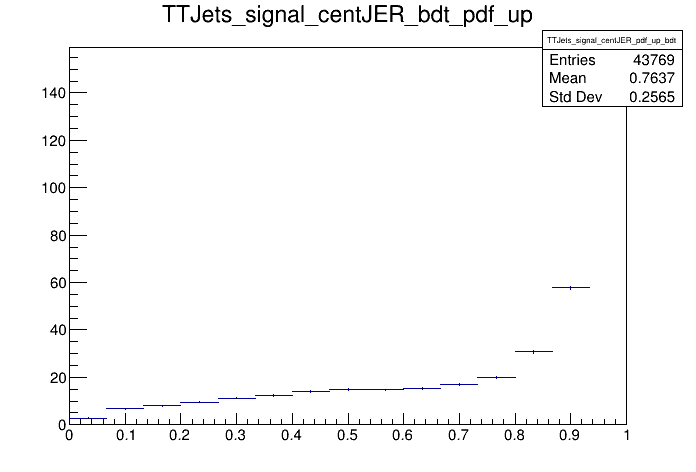

In [34]:
c = ROOT.TCanvas()
h.Draw()
c.Draw()

## Stack

In [20]:
import stack

In [21]:
#importlib.reload(stack)
sample_names = ["TTJets_bkg", "WZJets", "STJets", "QCD", "TTJets_signal"]
sfs = {}
sfs["TTJets_signal"] = 1.
sfs["QCD"] = 0.73
for var in variables:
    stack.plot( "histos/" + "bdt_nb" + ".root", var["var_name"], var["xtitle"], sample_names, sfs=sfs, corr = "central" )

Scaling QCD by 0.73
Scaling TTJets_signal by 1.0


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file stacks_corr/bdt_central_postfit.png has been created


## Syst

In [10]:
import ROOT

In [11]:
f = ROOT.TFile("histos/bdt_nb.root")

In [14]:
f.Get("TTJets_signal_centJER_btag_down_bdt")

<ROOT.TH1D object ("TTJets_signal_centJER_btag_down_bdt") at 0x813fb10>

In [21]:
importlib.reload(plot)
plot.syst(variables, sample = "TTJets_signal", file_name = "bdt_nb")

<class 'ROOT.TH1D'>
TTJets_signal_centJER_bdt
<class 'ROOT.TH1D'>
TTJets_signal_centJER_btag_up_bdt
TTJets_signal_centJER_btag_down_bdt
<class 'ROOT.TH1D'>
bdt bdt
<class 'ROOT.TH1D'>
TTJets_signal_centJER_trigger_up_bdt
TTJets_signal_centJER_trigger_down_bdt
<class 'ROOT.TH1D'>
bdt bdt
<class 'ROOT.TH1D'>
TTJets_signal_centJER_xsec_up_bdt
TTJets_signal_centJER_xsec_down_bdt
<class 'ROOT.TH1D'>
bdt bdt
<class 'ROOT.TH1D'>
TTJets_signal_centJER_pdf_up_bdt
TTJets_signal_centJER_pdf_down_bdt
<class 'ROOT.TH1D'>
bdt bdt
bdt bdt
bdt bdt
bdt bdt
bdt bdt
bdt bdt


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file syst/bdt_btag.png has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file syst/bdt_trigger.png has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file syst/bdt_xsec.png has been created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of s

In [ ]:
TTJets_signal_centJER_btag_up_bdt
TTJets_signal_centJER_btag_up_bdt

## Fit

In [13]:
import fit

In [24]:
#importlib.reload(fit)

syst=True

sample_names = ["Data", "TTJets_bkg", "WZJets", "STJets", "QCD", "TTJets_signal"]
sf_tt_sig, sf_qcd = fit.fit("histos/" + "bdt_nb" + ".root", sample_names, "bdt", corr="centJER")
sfs = {}
sfs["TTJets_signal"] = sf_tt_sig
sfs["QCD"] = sf_qcd
#stack.plot( "histos/" + file_name + ".root", var, sample_names[1:], sfs )

if syst:

    # PU - not applied
    # JES/JER/TauScale/MET
    for c in  ["jes_up", "jes_down", "jes_up_old", "jes_down_old", "jer_up", "jer_down", "tau_eup", "tau_edown",
               "met_up", "met_down"]:
        sf_tt_sig, sf_qcd = fit.fit("histos/" + "bdt_nb" + ".root", sample_names, "bdt", corr=c)     
        sfs["TTJets_signal_" + c] = sf_tt_sig
        
    # B-tagging, Trigger stat, XSEC theory, PDF
    for c in ["btag_up", "btag_down", "trigger_up", "trigger_down", "xsec_up", "xsec_down", "pdf_up", "pdf_down"]:
        sf_tt_sig, sf_qcd = fit.fit("histos/" + "bdt_nb" + ".root", sample_names, "bdt", corr = "centJER_" + c)     
        sfs["TTJets_signal_" + c] = sf_tt_sig

Data_bdt
Data 3343.0
TTJets_bkg_centJER_bdt
TTJets_bkg 143.2548703377998
WZJets_centJER_bdt
WZJets 63.342947935142455
STJets_centJER_bdt
STJets 30.165996274894944
QCD_bdt
QCD 3803.0034445550423
TTJets_signal_centJER_bdt
TTJets_signal 347.1281179556397
scale factor TTbar tau(h) QQ  0.9214735847990575 +- 0.07791342052562594
scale factor MultiJet  0.7326753274979056 +- 0.007111731405152924
Data_bdt
Data 3343.0
TTJets_bkg_jes_up_bdt
TTJets_bkg 145.76828344086593
WZJets_jes_up_bdt
WZJets 65.15419346825847
STJets_jes_up_bdt
STJets 30.935160310569525
QCD_bdt
QCD 3803.0034445550423
TTJets_signal_jes_up_bdt
TTJets_signal 354.6369360690969
scale factor TTbar tau(h) QQ  0.9073829655543513 +- 0.07655581246915763
scale factor MultiJet  0.7308304839992089 +- 0.007138967704910655
Data_bdt
Data 3343.0
TTJets_bkg_jes_down_bdt
TTJets_bkg 140.42892027660224
WZJets_jes_down_bdt
WZJets 62.434014152392876
STJets_jes_down_bdt
STJets 29.514357300815963
QCD_bdt
QCD 3803.0034445550423
TTJets_signal_jes_down_bdt

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure al

In [25]:
sfs

{'TTJets_signal': 0.9214735847990575,
 'QCD': 0.7326753274979056,
 'TTJets_signal_jes_up': 0.9073829655543513,
 'TTJets_signal_jes_down': 0.9379497171282354,
 'TTJets_signal_jes_up_old': 0.9055324626482582,
 'TTJets_signal_jes_down_old': 0.9433344245523222,
 'TTJets_signal_jer_up': 0.926566087047167,
 'TTJets_signal_jer_down': 0.9169003961745567,
 'TTJets_signal_tau_eup': 0.9010504163419091,
 'TTJets_signal_tau_edown': 0.9812991582128759,
 'TTJets_signal_met_up': 0.9163804015139916,
 'TTJets_signal_met_down': 0.9121222228996663,
 'TTJets_signal_btag_up': 0.8970466011707324,
 'TTJets_signal_btag_down': 0.9472435772021791,
 'TTJets_signal_trigger_up': 0.8861901800043589,
 'TTJets_signal_trigger_down': 0.9578592908616802,
 'TTJets_signal_xsec_up': 0.8472600249634797,
 'TTJets_signal_xsec_down': 1.0055200182853785,
 'TTJets_signal_pdf_up': 0.812587397747121,
 'TTJets_signal_pdf_down': 1.045127011948263}

In [26]:
for sample, sf in sfs.items():
    if "TTJets" in sample:
        print( sample, (sfs["TTJets_signal"] - sf) / sfs["TTJets_signal"] )

TTJets_signal 0.0
TTJets_signal_jes_up 0.015291397905647961
TTJets_signal_jes_down -0.01788020036707919
TTJets_signal_jes_up_old 0.017299597529185355
TTJets_signal_jes_down_old -0.023723783420261373
TTJets_signal_jer_up -0.005526476647966024
TTJets_signal_jer_down 0.0049629079986032425
TTJets_signal_tau_eup 0.022163596215947993
TTJets_signal_tau_edown -0.06492380725907015
TTJets_signal_met_up 0.005527215721736146
TTJets_signal_met_down 0.010148269091653289
TTJets_signal_btag_up 0.026508609721733672
TTJets_signal_btag_down -0.027966067425298124
TTJets_signal_trigger_up 0.03829019667708948
TTJets_signal_trigger_down -0.0394864341885147
TTJets_signal_xsec_up 0.0805379134679821
TTJets_signal_xsec_down -0.09120872792533573
TTJets_signal_pdf_up 0.11816528313796533
TTJets_signal_pdf_down -0.13419096237703887
